In [64]:
import torch
import pandas as pd
import warnings
from pandas.plotting import parallel_coordinates
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.exceptions import DataConversionWarning
import matplotlib.pyplot as plt


# BoTorch imports
import botorch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.optim import optimize_acqf
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.exceptions.warnings import InputDataWarning
import torch.optim as optim

print(f"Using BoTorch version: {botorch.__version__}")

Using BoTorch version: 0.14.0


# Load and Prepare data

In [65]:
# (Here we load and prepare our dataset for modeling)
# (We ensure no missing values and convert categorical variables to numeric)
df = pd.read_csv("processed_bank_marketing.csv")
df = df.dropna()

# Extract features, labels, and protected attribute
X = df.drop(columns=["deposit"])
y = df["deposit"].values
protected_attr = df["marital"].values  # 0, 1, 2 → single, married, divorced

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Change all tensor creations to use torch.float64 (double precision)
X_scaled = torch.tensor(X_scaled, dtype=torch.float64)  # Changed from float32 since BoTorch documentation suggests using double precision
y = torch.tensor(y, dtype=torch.float64).view(-1, 1)


# Split data into train/test sets
X_train, X_test, y_train, y_test, m_train, m_test = train_test_split(
    X_scaled, y, protected_attr, test_size=0.2, random_state=42
)
m_test

array([0, 1, 2, ..., 1, 1, 1], shape=(2233,))

# Define fairness metric and Evaluation function for Random Forest

In [66]:
# We define demographic parity difference as our fairness metric
# This measures the maximum difference in positive prediction rates between groups
def demographic_parity_diff(y_pred, protected_group):
    group_probs = [
        y_pred[protected_group == g].mean()
        for g in np.unique(protected_group)
    ]
    return max(group_probs) - min(group_probs)

# This function trains and evaluates a Random Forest with given parameters
# It returns both accuracy and fairness metrics for multi-objective optimization
def train_and_evaluate_rf(params):
    n_estimators = int(params[0].item())
    max_depth = int(params[1].item()) if params[1].item() > 0 else None
    min_samples_split = int(params[2].item())
    min_samples_leaf = int(params[3].item())
    
    print(f"Training RF with: n_estimators={n_estimators}, max_depth={max_depth}, "
          f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}")
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    fairness = demographic_parity_diff(y_pred, m_test)
    
    print(f"  Results: Accuracy = {acc:.4f}, Fairness = {fairness:.4f}")
    
    return torch.tensor([acc, -fairness], dtype=torch.float64)

# GP model fitting helper function

In [67]:
# This manually fits a Gaussian Process model using Adam optimizer
# We use this instead of the built-in fit function for more control

def manual_fit_gp(model, train_x, train_y, training_iter=100, lr=0.1):
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    
    return model

# Define parameter bounds and initial points

In [68]:
# These bounds define the search space for our hyperparameters
bounds = torch.tensor([
    [10.0, 1.0, 2.0, 1.0],     # lower bounds
    [300.0, 30.0, 20.0, 10.0]  # upper bounds
], dtype=torch.float64)

warnings.filterwarnings("ignore", category=InputDataWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

# This generates initial random points to start the optimization
def generate_initial_points(n_samples=10):
    print(f"Generating {n_samples} initial random points...")
    X_init = torch.rand(n_samples, 4)
    X_init = bounds[0] + X_init * (bounds[1] - bounds[0])
    
    Y_init = torch.zeros(n_samples, 2)
    
    for i in range(n_samples):
        results = train_and_evaluate_rf(X_init[i])
        Y_init[i] = results
        print(f"  Trial {i+1}: acc={results[0]:.4f}, fairness={-results[1]:.4f}")
        
    return X_init, Y_init

# Main optimization loop

In [69]:
# This implements the multi-objective Bayesian optimization using BoTorch
# We use Expected Hypervolume Improvement as our acquisition function

def run_botorch_multi_objective_optimization(n_iterations=60):
    print("Initializing with random trials...")
    X_train, Y_train = generate_initial_points(n_samples=25)
    
    all_X = X_train.clone()
    all_Y = Y_train.clone()
    
    # Reference point for hypervolume calculation
    ref_point = torch.tensor([0.5, -0.3])  # 50% accuracy, 0.3 fairness difference
    
    print(f"Starting optimization for {n_iterations} iterations...")
    
    for i in range(n_iterations):
        try:
            # Fit separate GP for each objective
            models = []
            for j in range(Y_train.shape[1]):
                gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
                gp = manual_fit_gp(gp, X_train, Y_train[:, j:j+1])
                models.append(gp)
            
            model = ModelListGP(*models)
            
            # Get current Pareto frontier
            pareto_Y = Y_train
            partitioning = NondominatedPartitioning(ref_point=ref_point, Y=pareto_Y)
            
            # Define acquisition function
            acq_func = ExpectedHypervolumeImprovement(
                model=model,
                ref_point=ref_point,
                partitioning=partitioning,
                objective=IdentityMCMultiOutputObjective()
            )
            
            # Optimize acquisition function
            candidate, _ = optimize_acqf(
                acq_function=acq_func,
                bounds=bounds,
                q=1,
                num_restarts=10,
                raw_samples=64
            )
            
        except Exception as e:
            print(f"Error in BoTorch optimization: {e}")
            candidate = bounds[0] + torch.rand(1, 4) * (bounds[1] - bounds[0])
        
        print(f"\nIteration {i+1}/{n_iterations}:")
        print(f"Candidate: n_estimators={int(candidate[0,0].item())}, max_depth={int(candidate[0,1].item())}, "
              f"min_samples_split={int(candidate[0,2].item())}, min_samples_leaf={int(candidate[0,3].item())}")
        
        results = train_and_evaluate_rf(candidate[0])
        
        X_train = torch.cat([X_train, candidate])
        Y_train = torch.cat([Y_train, results.unsqueeze(0)])
        
        all_X = torch.cat([all_X, candidate])
        all_Y = torch.cat([all_Y, results.unsqueeze(0)])
        
    return all_X, all_Y

In [70]:
#  Run the optimization and extract results
# (This executes the optimization and prepares results for visualization)
print("Starting Multi-Objective BoTorch optimization for Random Forest...")
all_X, all_Y = run_botorch_multi_objective_optimization(n_iterations=400)

# Extract accuracy and fairness values
accuracies = all_Y[:, 0].numpy()
fairness_values = -all_Y[:, 1].numpy()

Starting Multi-Objective BoTorch optimization for Random Forest...
Initializing with random trials...
Generating 25 initial random points...
Training RF with: n_estimators=17, max_depth=22, min_samples_split=8, min_samples_leaf=5
  Results: Accuracy = 0.8325, Fairness = 0.1077
  Trial 1: acc=0.8325, fairness=0.1077
Training RF with: n_estimators=194, max_depth=17, min_samples_split=8, min_samples_leaf=9
  Results: Accuracy = 0.8240, Fairness = 0.1232
  Trial 2: acc=0.8240, fairness=0.1232
Training RF with: n_estimators=161, max_depth=11, min_samples_split=4, min_samples_leaf=6
  Results: Accuracy = 0.8271, Fairness = 0.1283
  Trial 3: acc=0.8271, fairness=0.1283
Training RF with: n_estimators=252, max_depth=28, min_samples_split=17, min_samples_leaf=4
  Results: Accuracy = 0.8240, Fairness = 0.1257
  Trial 4: acc=0.8240, fairness=0.1257
Training RF with: n_estimators=220, max_depth=6, min_samples_split=14, min_samples_leaf=2
  Results: Accuracy = 0.8061, Fairness = 0.0840
  Trial 5: ac

In [71]:
# Helper function for Pareto frontier identification
# This identifies which points are Pareto-optimal
# A point is Pareto-optimal if no other point is better in both objectives
def is_pareto_optimal(accuracies, fairness_values, idx):
    for i in range(len(accuracies)):
        if i != idx:
            if accuracies[i] >= accuracies[idx] and fairness_values[i] <= fairness_values[idx] and (
                accuracies[i] > accuracies[idx] or fairness_values[i] < fairness_values[idx]
            ):
                return False
    return True

# Find Pareto-optimal points
pareto_optimal = [
    is_pareto_optimal(accuracies, fairness_values, i)
    for i in range(len(accuracies))
]

# Extract and sort Pareto-optimal solutions
pareto_accuracies = accuracies[pareto_optimal]
pareto_fairness = fairness_values[pareto_optimal]
pareto_indices = np.where(pareto_optimal)[0]
pareto_sort_idx = np.argsort(pareto_accuracies)
pareto_accuracies = pareto_accuracies[pareto_sort_idx]
pareto_fairness = pareto_fairness[pareto_sort_idx]
pareto_indices = pareto_indices[pareto_sort_idx]
pareto_params = all_X[pareto_indices].numpy()

#  Visualize all trials and Pareto frontier

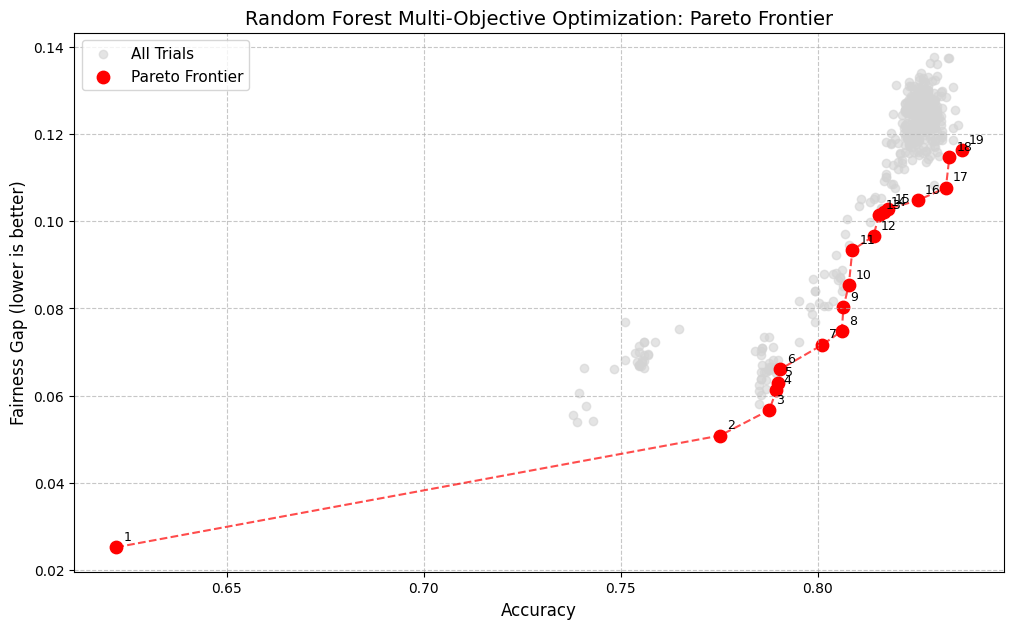

In [72]:
# This creates the main visualization showing the trade-off between accuracy and fairness
plt.figure(figsize=(12, 7))
plt.scatter(accuracies, fairness_values, color="lightgray", alpha=0.6, label="All Trials")
plt.scatter(pareto_accuracies, pareto_fairness, color="red", s=80, label="Pareto Frontier")
plt.plot(pareto_accuracies, pareto_fairness, 'r--', alpha=0.7)

# Add annotations
for i, (x, y) in enumerate(zip(pareto_accuracies, pareto_fairness)):
    plt.annotate(f"{i+1}", (x, y), textcoords="offset points", xytext=(5, 5), fontsize=9)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Fairness Gap (lower is better)", fontsize=12)
plt.title("Random Forest Multi-Objective Optimization: Pareto Frontier", fontsize=14)
plt.legend(fontsize=11)
plt.show()

# Print Pareto-optimal configurations

In [73]:
# This displays the actual parameter settings for each Pareto-optimal solution
print("\nPareto-Optimal Random Forest Configurations:")
for i in range(len(pareto_indices)):
    idx = pareto_indices[i]
    max_depth_val = int(all_X[idx, 1].item())
    max_depth_str = str(max_depth_val) if max_depth_val > 0 else "None"
    params = {
        "n_estimators": int(all_X[idx, 0].item()),
        "max_depth": max_depth_str,
        "min_samples_split": int(all_X[idx, 2].item()),
        "min_samples_leaf": int(all_X[idx, 3].item())
    }
    print(f"{i+1}. n_estimators={params['n_estimators']}, max_depth={params['max_depth']}, " 
            f"min_samples_split={params['min_samples_split']}, min_samples_leaf={params['min_samples_leaf']}, "
            f"acc={accuracies[idx]:.4f}, fairness={fairness_values[idx]:.4f}")


Pareto-Optimal Random Forest Configurations:
1. n_estimators=21, max_depth=1, min_samples_split=14, min_samples_leaf=2, acc=0.6220, fairness=0.0252
2. n_estimators=22, max_depth=3, min_samples_split=5, min_samples_leaf=6, acc=0.7752, fairness=0.0508
3. n_estimators=27, max_depth=4, min_samples_split=9, min_samples_leaf=5, acc=0.7877, fairness=0.0567
4. n_estimators=136, max_depth=4, min_samples_split=16, min_samples_leaf=4, acc=0.7895, fairness=0.0613
5. n_estimators=87, max_depth=4, min_samples_split=3, min_samples_leaf=1, acc=0.7900, fairness=0.0630
6. n_estimators=185, max_depth=4, min_samples_split=11, min_samples_leaf=1, acc=0.7904, fairness=0.0660
7. n_estimators=207, max_depth=5, min_samples_split=8, min_samples_leaf=1, acc=0.8012, fairness=0.0717
8. n_estimators=21, max_depth=6, min_samples_split=3, min_samples_leaf=4, acc=0.8061, fairness=0.0748
9. n_estimators=213, max_depth=6, min_samples_split=9, min_samples_leaf=1, acc=0.8065, fairness=0.0803
10. n_estimators=251, max_dep

In [74]:
import csv
with open('pareto_results.csv', 'a', newline='') as f:
    writer = csv.writer(f)
    for i in range(len(pareto_indices)):
        idx = pareto_indices[i]
        params = {
            "n_estimators": int(all_X[idx, 0].item()),
            "max_depth": int(all_X[idx, 1].item()),
            "min_samples_split": all_X[idx, 2].item()
        }
        writer.writerow([
            'Botorch', 'RF',
            accuracies[idx],
            fairness_values[idx],
            str(params)
        ])

# Additional visualizations - Parallel Coordinates

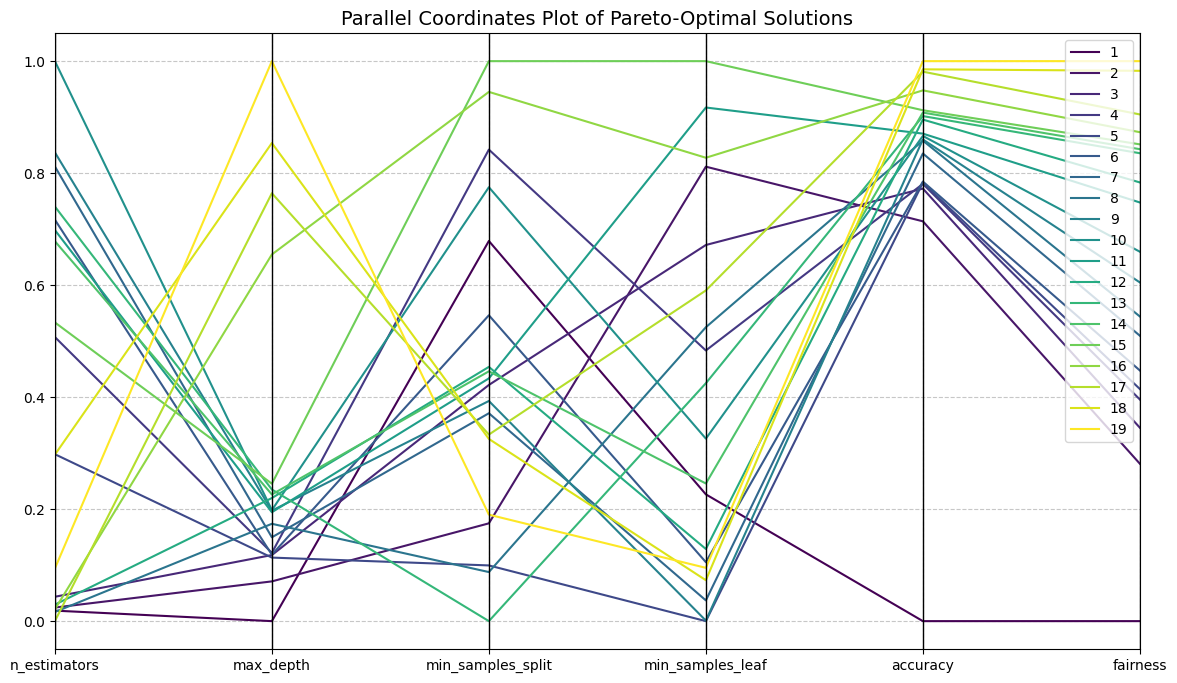

In [75]:
# (This shows how different parameters affect the objectives)
# (Helps identify patterns in good configurations)

pareto_df = pd.DataFrame({
    'n_estimators': pareto_params[:, 0],
    'max_depth': pareto_params[:, 1],
    'min_samples_split': pareto_params[:, 2],
    'min_samples_leaf': pareto_params[:, 3],
    'accuracy': pareto_accuracies,
    'fairness': pareto_fairness,
    'config_id': range(1, len(pareto_params) + 1)
})

# Normalize for visualization
for col in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'accuracy', 'fairness']:
    pareto_df[col] = (pareto_df[col] - pareto_df[col].min()) / (pareto_df[col].max() - pareto_df[col].min() + 1e-10)

plt.figure(figsize=(14, 8))
parallel_coordinates(pareto_df, 'config_id', colormap='viridis')
plt.title('Parallel Coordinates Plot of Pareto-Optimal Solutions', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#  3D Parameter Space Visualization

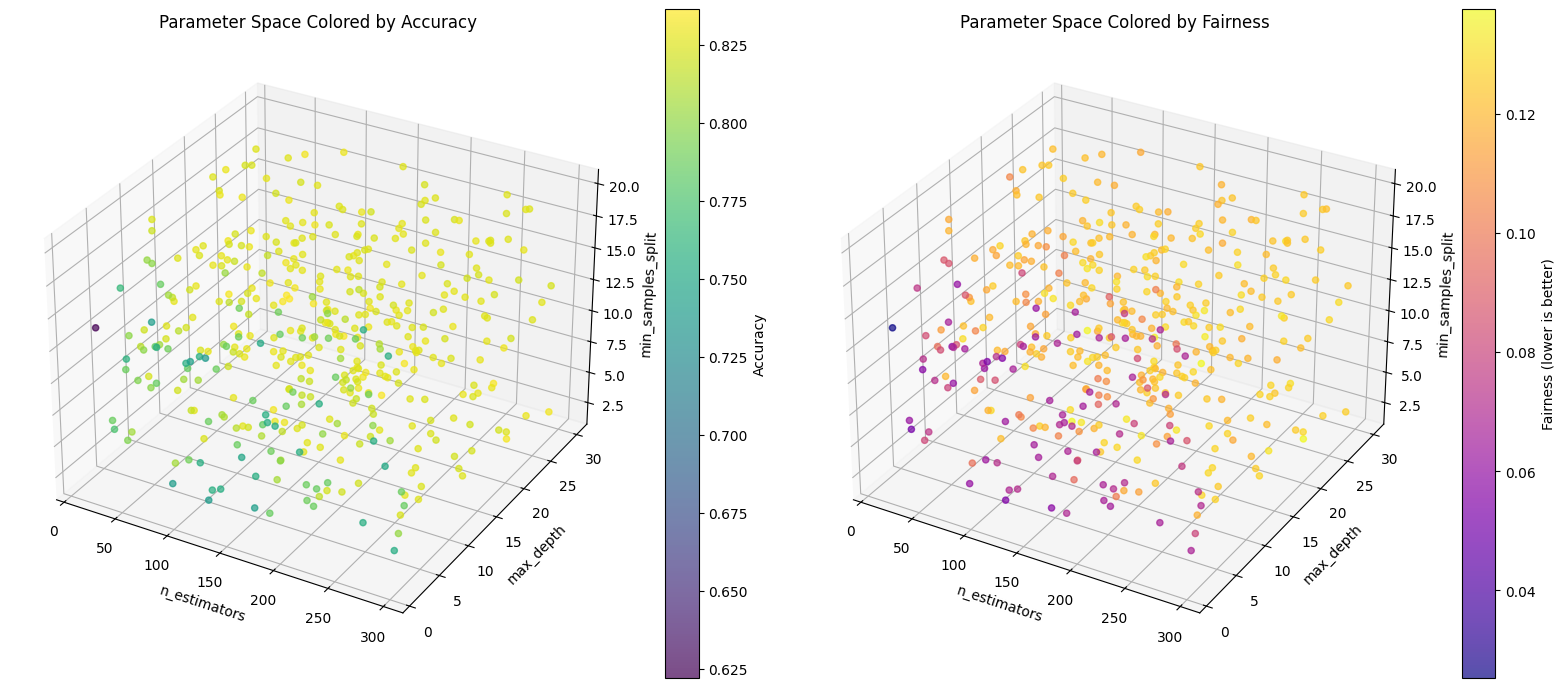

In [76]:
# Shows how parameters relate to each other and to the objectives
fig = plt.figure(figsize=(16, 7))

# Plot 1: Colored by accuracy
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(
    all_X[:, 0].numpy(),
    all_X[:, 1].numpy(),
    all_X[:, 2].numpy(),
    c=accuracies,
    cmap='viridis',
    alpha=0.7
)
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('max_depth')
ax1.set_zlabel('min_samples_split')
plt.colorbar(scatter1, ax=ax1, label='Accuracy')
ax1.set_title('Parameter Space Colored by Accuracy')

# Plot 2: Colored by fairness
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(
    all_X[:, 0].numpy(),
    all_X[:, 1].numpy(),
    all_X[:, 2].numpy(),
    c=fairness_values,
    cmap='plasma',
    alpha=0.7
)
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('max_depth')
ax2.set_zlabel('min_samples_split')
plt.colorbar(scatter2, ax=ax2, label='Fairness (lower is better)')
ax2.set_title('Parameter Space Colored by Fairness')

plt.tight_layout()
plt.show()

# Final analysis - compare best models

In [77]:
# Identifies and compares the best accuracy, most fair, and compromise models
best_acc_idx = np.argmax(accuracies)
best_fair_idx = np.argmin(fairness_values)

# Normalize objectives for compromise solution
normalized_acc = (pareto_accuracies - np.min(accuracies)) / (np.max(accuracies) - np.min(accuracies))
normalized_fair = (pareto_fairness - np.min(fairness_values)) / (np.max(fairness_values) - np.min(fairness_values))
distances = np.sqrt((1 - normalized_acc)**2 + normalized_fair**2)
compromise_idx = np.argmin(distances)
compromise_real_idx = pareto_indices[compromise_idx]

print("\nBest Accuracy Model:")
max_depth_val = int(all_X[best_acc_idx, 1].item())
max_depth_str = str(max_depth_val) if max_depth_val > 0 else "None"
print(f"Parameters: n_estimators={int(all_X[best_acc_idx, 0].item())}, max_depth={max_depth_str}, "
      f"min_samples_split={int(all_X[best_acc_idx, 2].item())}, min_samples_leaf={int(all_X[best_acc_idx, 3].item())}")
print(f"Performance: Accuracy = {accuracies[best_acc_idx]:.4f}, Fairness Gap = {fairness_values[best_acc_idx]:.4f}")

print("\nMost Fair Model:")
max_depth_val = int(all_X[best_fair_idx, 1].item())
max_depth_str = str(max_depth_val) if max_depth_val > 0 else "None"
print(f"Parameters: n_estimators={int(all_X[best_fair_idx, 0].item())}, max_depth={max_depth_str}, "
      f"min_samples_split={int(all_X[best_fair_idx, 2].item())}, min_samples_leaf={int(all_X[best_fair_idx, 3].item())}")
print(f"Performance: Accuracy = {accuracies[best_fair_idx]:.4f}, Fairness Gap = {fairness_values[best_fair_idx]:.4f}")

print("\nCompromise Model (balancing accuracy and fairness):")
max_depth_val = int(all_X[compromise_real_idx, 1].item())
max_depth_str = str(max_depth_val) if max_depth_val > 0 else "None"
print(f"Parameters: n_estimators={int(all_X[compromise_real_idx, 0].item())}, max_depth={max_depth_str}, "
      f"min_samples_split={int(all_X[compromise_real_idx, 2].item())}, min_samples_leaf={int(all_X[compromise_real_idx, 3].item())}")
print(f"Performance: Accuracy = {accuracies[compromise_real_idx]:.4f}, Fairness Gap = {fairness_values[compromise_real_idx]:.4f}")


Best Accuracy Model:
Parameters: n_estimators=39, max_depth=29, min_samples_split=5, min_samples_leaf=1
Performance: Accuracy = 0.8365, Fairness Gap = 0.1163

Most Fair Model:
Parameters: n_estimators=21, max_depth=1, min_samples_split=14, min_samples_leaf=2
Performance: Accuracy = 0.6220, Fairness Gap = 0.0252

Compromise Model (balancing accuracy and fairness):
Parameters: n_estimators=27, max_depth=4, min_samples_split=9, min_samples_leaf=5
Performance: Accuracy = 0.7877, Fairness Gap = 0.0567
